In [1]:
from Deproject_v0 import *
from Deproject_test import *
from Deproject_plots import *

plt.style.use('classic')

## Deprojection of velocities for solar vicinity stars

The purpose of the code is to infer the velocity distribution $f(\boldsymbol{v})$ of solar neighbourhood stars through numerical maximization of the following function from (Dehnen, 1998):

\begin{equation}
\tilde{\mathcal{L}}_\alpha (\phi) = N^{-1} \sum_k \ln \left[ \sum_\boldsymbol{l} e^{\phi_\boldsymbol{l}} \right] - \sum_\boldsymbol{l} e^{\phi_\boldsymbol{l}} - \frac{1}{2}\alpha h_x h_y h_z \sum_\boldsymbol{l} \left( \sum_\boldsymbol{n} \phi_\boldsymbol{n} \Xi_\boldsymbol{nl} \right).
\end{equation}

Each term is computed using different sections in the code, which then are combined in the function $\texttt{get_negL}$. Said function is then maximized using the conjugate gradient algorithm.

We begin by initiating our data. This can be done by either reading data from a file or by creating a pseudosample of stars with a given Gaussian velocity dispersion. The latter can be used to test the program and to see that the maximization scheme is working as intended.

The data is transformed to a Galactic (l,b) frame of reference with the use of the astropy library.

In [2]:
#Initiation of data, now loading GRD1 data and setting up the various parameters used in the code below

try:
    data_raw
except NameError:
    
    data_raw = ascii.read('Distances_PJM2017.csv', format='fast_csv')
    
RA = data_raw['RAdeg']*u.degree
DEC = data_raw['DEdeg']*u.degree
pm_RA = data_raw['pmRA_TGAS']*u.mas/u.yr
pm_DEC = data_raw['pmDE_TGAS']*u.mas/u.yr
parallax = data_raw['parallax']*u.mas

dist = parallax.to(u.kpc,equivalencies=u.parallax())

near_stars = np.where(dist.value<0.1)

sample_raw = coord.ICRS(ra = RA, dec = DEC, pm_ra_cosdec = pm_RA, pm_dec = pm_DEC,distance=dist)

sample = sample_raw[near_stars]

sample = sample.transform_to(coord.Galactic)

If we choose to use pseudodata instead, we can specify the desired number of stars, $N$, as well as the mean velocities and dispersions for the Gaussian velocity distribution of each component $v_x,\ v_y,\ v_z$. The pseudosample can then be generated using the $\texttt{model_sample}$ function.

In [64]:
N = 2000 #Number of stars we want to use in our sample
v0 = np.array([0,0,0]) #The mean velocities of our pseudosample Gaussian velocity distributions
v_disp = np.array([50,50,50]) #The velocity dispersions of the Gaussians
sample = model_sample(N,v0,v_disp) #Uncomment to use pseudosample

With a set of stars at hand we can use the method of projection from (Dehnen & Binney, 1998) to compute the proper motion velocity $p$. We correct the observed proper motions, using the Oort constant values from (Bovy, 2018).

In [4]:
#Oort constant values from Bovy (2018)
A = (15.3*(u.km/(u.s*u.kpc))).to(1/u.yr)
B = (-11.9*(u.km/(u.s*u.kpc))).to(1/u.yr)

bvals = sample.b.to(u.deg)
lvals = sample.l.to(u.deg)

mul_obs = sample.pm_l.to(1/u.yr,equivalencies = u.dimensionless_angles())
mub_obs = sample.pm_b.to(1/u.yr,equivalencies = u.dimensionless_angles())

"""Computation of the relevant quantities

    l,b: Galactic coordinates
    s: the distance obtained by inverting the parallax
    mul, mub: proper motion in l and b
    pvals: Tangential velocities obtained from eq. 2 in DB98
    rhatvals: The unit vector of each star
    vmin: Vector containing the minimum velocities in v-space
    n: The number of cells we want in each dimension of our v-space box
    dv: Step sizes for each dimension"""

b = np.deg2rad(bvals).value # just a test
l = np.deg2rad(lvals).value
cosl = np.cos(l)
cosb = np.cos(b)
sinl = np.sin(l)
sinb = np.sin(b)
s = sample.distance

mul = mul_obs - A*np.cos(2*l)-B
mub = mub_obs + A*np.sin(2*l)*cosb*sinb

pvals = s*np.array([-sinl*cosb*mul - cosl*sinb*mub,
                 cosl*cosb*mul - sinl*sinb*mub,
                 cosb*mub])/u.yr
    
rhatvals = np.array([cosb*cosl, cosb*sinl, sinb]).T
pvals = pvals.to(u.km/u.s).value.T

Our method of inferring the velocity distribution $f(\boldsymbol{v})$ is based on the assumption that the velocity distribution must be positive. Hence we can define $f(\boldsymbol{v}) = e^{\phi(\boldsymbol{v})}$. 

We thus look to find $\phi(\boldsymbol{v})$, which can be done by creating a box of lengths $n = n_x\times n_y\times n_z$ of sides $d_{vx},\ d_{vy},\ d_{vz}$. We also have to specify the lower edge of our box by defining $v_{min}$.

Hence we get a box that covers the ranges $v_i \in [v_{i,min},v_{i,min}+n_i d_{vi}]$, where $i = x,y,z$.

In [65]:
n = np.array([20,20,20])
dv = np.array([20,20,20])
vmin = np.array([-200,-200,-200]) 

Essentially, we project the possible values of the radial velocity for each star $k$ in order to get an estimate of the velocity probability distribution function.

In [66]:
def get_negL(phi,*args):
    
    """The function that we wish to optimise."""
    
    Kvals, N, alpha, dv, n, sigma2 = args
    nx, ny, nz = n
    dvx, dvy, dvz = dv
    
    """We regain the original shape of our phi guess and proceed to compute the various quantities needed from our functions."""
    
    phi_unr = np.reshape(phi,n)
    
    phixhi = sec_der(phi_unr,sigma2,dv) #last term
    exphi = np.exp(phi_unr)
    
    Kphi = exphi*Kvals
    Kphiord = Kphi.reshape(len(Kphi),nx*ny*nz) #Order all Kphi values in 1D arrays for each star
    Kphi_sum = np.sum(Kphiord,axis=1) #We compute the sum of exp(phi)*K(k|l) for each star
    
    notzero = Kphi_sum != 0
    Kphi_sum[notzero] = np.log(Kphi_sum[notzero]) #To make sure we don't get infinities
    Kphi_sum_tot = np.sum(Kphi_sum) #Gives the double sum in the first term
        
    L_tilde = Kphi_sum_tot/N - np.sum(exphi)-((alpha*dvx*dvy*dvz)/2)*np.sum(phixhi**2) #eq. 31 in DB98
    
    negL = -1*L_tilde #Since we want to maximize L_tilde, we should minimize -L_tilde 
    
    return negL

In [67]:
def get_grad_negL(phi,*args):
    
    """In this function we compute the gradient of L. We compute the derivative for each cell and return a 
    1D array of length (nx*ny*nz)."""
    
    Kvals, N, alpha, dv, n, sigma2 = args
    dvx, dvy, dvz = dv
    nx, ny, nz = n
    
    phi_unr = np.reshape(phi,n)
    exphi = np.exp(phi_unr)
    
    Kvalsord = Kvals.reshape(len(Kvals),nx*ny*nz)
    Kphi = exphi*Kvals
    Kphiord = Kphi.reshape(len(Kphi),nx*ny*nz) #Order all Kphi values in 1D arrays for each star
    Kphi_sum = np.sum(Kphiord,axis=1) #We compute the sum of exp(phi)*K(k|l) for each star
    Kphistack = np.stack([Kphi_sum]*nx*ny*nz,axis=1) #Creates a stack of Kphi_sums that is used to estimate the sum over k
    
    #We first create an array of shape (N,nx*ny*nz) and then sum over all of the stars to obtain the first term
    
    K_term0 = Kphiord / Kphistack
    K_term = np.sum(K_term0,axis=0) #The final array with the first term for each cell
    
    kappa_sum = -2*sum(sigma2/dv**2)
    
    dphixhi = sec_der(phi_unr,sigma2,dv)*kappa_sum #last term
    dphixhi_rav = np.ravel(dphixhi) #We ravel to obtain a 1D array of length nx*ny*nz

    grad_L = K_term/N-np.exp(phi)-(alpha*dvx*dvy*dvz)*dphixhi_rav
    
    grad_negL = -1*grad_L
    
    return grad_negL

In [68]:
def max_L(v0_guess,disp_guess,alpha, pvals, rhatvals, vmin, dv, n):
    
    """Function that employs scipy.optimize.fmin_cg to maximise the function get_negL().
    It takes guesses of the distribution (currently only supports Gaussian guesses) and the relevant data from the
    star sample for which the velocity distribution is to be estimated."""
    
    dvx, dvy, dvz = dv
    nx, ny, nz = n
    
    N = len(pvals)
    
    phi0 = phi_guess(v0_guess,disp_guess,vmin,dv,n) #We obtain phi given our initial guess of the velocity distribution
    
    sigma2 = calc_sigma2(pvals,rhatvals) 
    
    Kvals = np.zeros((N,nx,ny,nz))
    
    for i in range(N):
        K = calc_K(pvals[i],rhatvals[i],vmin,dv,n)
        Kvals[i] += K   
        
    args = (Kvals, N, alpha, dv, n, sigma2)
    
    phi0 = np.ravel(phi0) #fmin_cg only takes one-dimensional inputs for the initial guess
    
    mxl, phi_all = fmin_cg(get_negL, phi0, fprime = get_grad_negL, args=args, retall=True)
    
    mxlnew = mxl.reshape(n)

    return mxlnew, phi_all
   
    #return get_negL(phi0, Kvals, N, alpha, dv, n, sigma2)

In [69]:
v_guess = np.array([2,1,-3])
disp_guess = np.array([20,40,30])

mxl, phi_all = max_L(v_guess, disp_guess,1e-14, pvals, rhatvals, vmin, dv, n)

         Current function value: 11.377137
         Iterations: 395
         Function evaluations: 3037
         Gradient evaluations: 3026


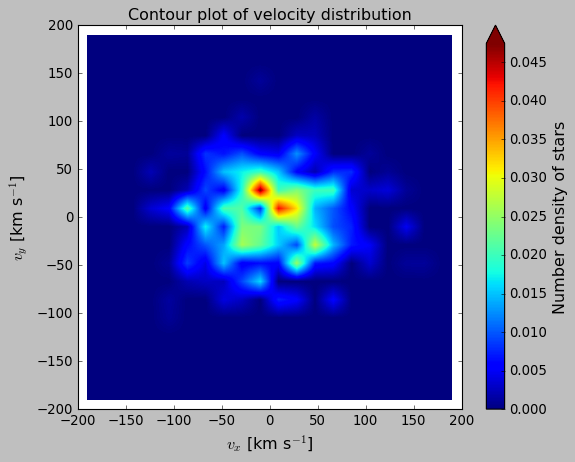

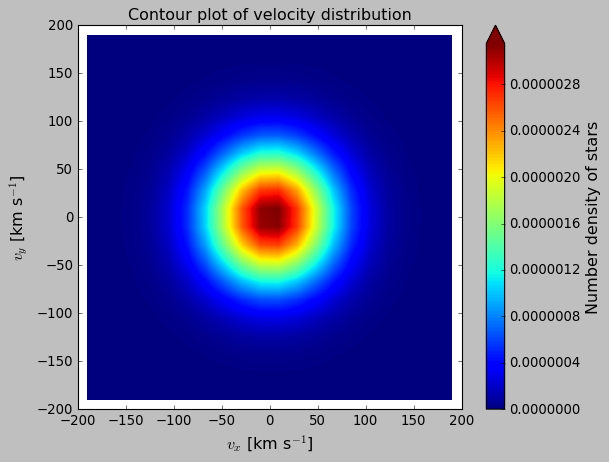

In [73]:
plot_fv(mxl,'xy',vmin,dv,n)

sigma2, vmean0 = calc_sigma2(pvals,rhatvals,True)

sigma = np.sqrt(sigma2)

phi0 = phi_guess(vmean0,sigma,vmin,dv,n)

plot_fv(phi0,'xy',vmin,dv,n)

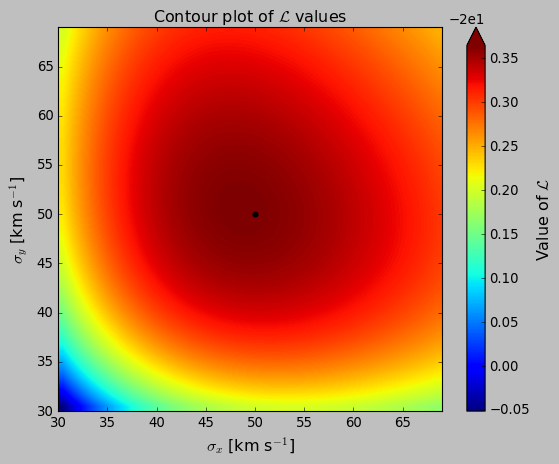

In [74]:
test_L('xy', 1e-13, v0, v_disp, pvals, rhatvals, vmin, dv, n)

In [71]:
sanity_check(pvals,rhatvals,mxl,vmin,dv,n)

(array([ 1.05899426,  1.78573858, -0.08643456]),
 array([ 50.60932986,  48.40286126,  46.8739051 ]),
 array([ 2.22139647,  0.9730453 , -2.10514412]),
 array([ 40.44611273,  51.86258379,  48.13400659]))

In [44]:
def grad_negL_test(phi0,pvals,alpha,vmin,dv,n):
    
    from scipy.optimize import check_grad
    from scipy.optimize import approx_fprime
    
    """Function that checks the change in L for a small step in phi and compares it to the value obtained using the
    get_grad_negL function."""
    
    dvx, dvy, dvz = dv
    nx, ny, nz = n

    N = len(pvals)

    sigma2 = calc_sigma2(pvals,rhatvals) 

    Kvals = np.zeros((N,nx,ny,nz))

    for i in range(N):
        K = calc_K(pvals[i],rhatvals[i],vmin,dv,n)
        Kvals[i] += K   

    phi0r = np.ravel(phi0)
    
    gest_L = np.zeros(len(phi0r))

    args = Kvals, N, alpha, dv, n, sigma2

    #gest_L = approx_fprime(phi0r,get_negL,1e-5,Kvals,N,alpha,dv,n,sigma2)
    gest_L = np.zeros(len(phi0r))
    
    d0 = np.zeros(len(phi0r))
    
    L0 = -get_negL(phi0r, Kvals, N, alpha, dv, n, sigma2)
    
    eps = 1e-6
   
    for i in range(len(phi0r)):
        d0[i] = 1
        
        d = d0*eps

        L1 = get_negL(phi0r+d, Kvals, N, alpha, dv, n, sigma2)
        
        gest_L[i] += (L1-L0)/d[i]
        
        d0[i] = 0
        
        if i == len(phi0r)/2:
            print('Halfway there')
    
    grad_negL = get_grad_negL(phi0r, Kvals, N, alpha, dv, n, sigma2)
    
    frac = gest_L/grad_L

    twonorm = check_grad(get_negL,get_grad_L,phi0r,Kvals, N, alpha, dv, n, sigma2)
    
    fig, ax = plt.subplots()
    ax.set_ylabel('$\mathrm{Counts}$')
    ax.set_xlabel('$\mathrm{grad}_{\mathcal{L},est}/\mathrm{grad}_\mathcal{L}$')
    ax.hist(frac,bins=100,range=(0,1.05))
    plt.show()
    
    return frac, gest_L, grad_negL, twonorm

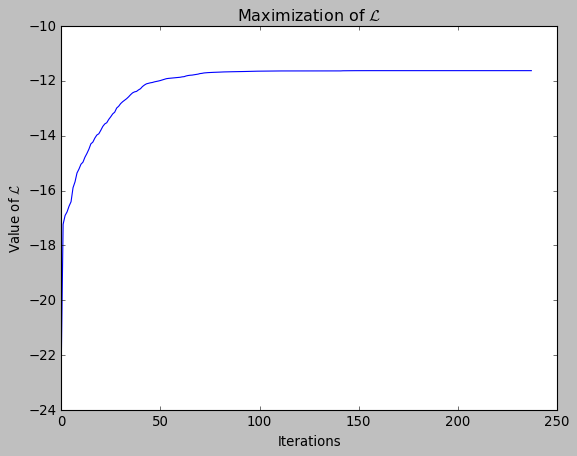

In [67]:
plot_L(phi_all,pvals,rhatvals,vmin,dv,n,1e-15)

Halfway there


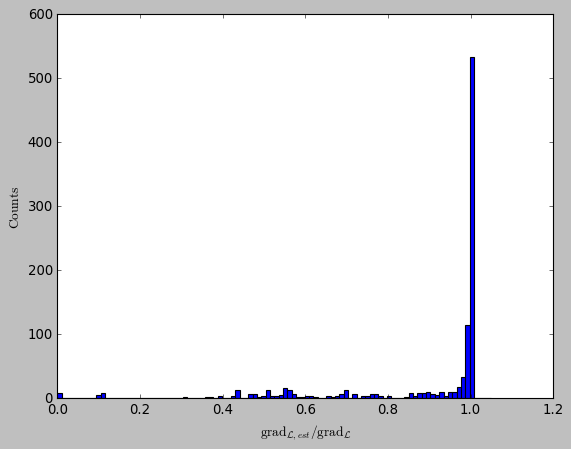

In [74]:
testvals, gL_est, gL, twon = grad_negL_test(phi0,pvals,1e-15,vmin,dv,n)

In [80]:
def plot_grad_negL(phi, plane, alpha, pvals, rhatvals, vmin, dv, n):
    
    from scipy.optimize import approx_fprime
    
    dvx, dvy, dvz = dv
    nx, ny, nz = n
    vxmin, vymin, vzmin = vmin
    vxmax, vymax, vzmax = vxmin+nx*dvx,vymin+ny*dvy,vzmin+nz*dvz
    
    N = len(pvals)
    
    sigma2 = calc_sigma2(pvals,rhatvals) 
    
    Kvals = np.zeros((N,nx,ny,nz))
    
    for i in range(N):
        K = calc_K(pvals[i],rhatvals[i],vmin,dv,n)
        Kvals[i] += K  
    
    if plane == 'xy':
        axsum = 2
        n1, n2 = nx, ny
        dx, dy = dvx, dvy
        x0, y0 = vxmin, vymin
        x1, y1 = vxmax, vymax
        xlab, ylab = '$v_x$', '$v_y$'
    elif plane == 'yz':
        axsum = 0
        n1, n2 = ny, nz
        dx, dy = dvy, dvz
        x0, y0 = vymin, vzmin
        x1, y1 = vymax, vzmax
        xlab, ylab = '$v_y$', '$v_z$'
    elif plane == 'xz':
        axsum = 1
        n1, n2 = nx, nz
        dx, dy = dvx, dvz
        x0, y0 = vxmin, vzmin
        x1, y1 = vxmax, vzmax
        xlab, ylab = '$v_x$', '$v_z$'
        
    phir = np.ravel(phi)
        
    gL_vals = -get_grad_negL(phir, Kvals, N, alpha, dv, n, sigma2)
    
    #gL_vals = approx_fprime(phir,get_negL,1e-5,Kvals,N,alpha,dv,n,sigma2)
    
    gL_unr = np.reshape(gL_vals, (nx,ny,nz))
    
    gLproj = np.sum(gL_unr,axis=axsum)
    
    xbins = np.arange(x0,x1+dx,dx)
    ybins = np.arange(y0,x1+dy,dy)
    
    xc = (xbins[1:]+xbins[:-1])/2
    yc = (ybins[1:]+ybins[:-1])/2
    
    fig, ax = plt.subplots(figsize=(8,6))
    
    ax.set_title(r'Contour plot of $\nabla \phi$')
    ax.set_xlim(x0,x1)
    ax.set_ylim(y0,y1)
    ax.set_xlabel(xlab+' [km s$^{-1}$]',size='large')
    ax.set_ylabel(ylab+' [km s$^{-1}$]',size='large')
    
    extent = [xc[0], xc[-1], yc[0], yc[-1]]
    im = ax.imshow(gLproj.T,origin='lower',interpolation='bilinear',vmin=gLproj.min(),vmax=gLproj.max(),cmap = plt.cm.get_cmap('jet'),extent=extent)
    
    cb = plt.colorbar(im,orientation='vertical', extend='max')
    #cb.ax.xaxis.get_ticklabels().set_visible(False)
    cb.set_label(r'Value of $\nabla\phi$',size='large')
    
    plt.show()
    
    return 

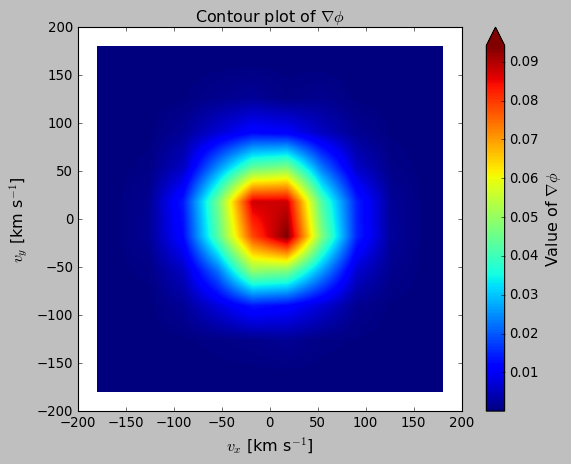

In [83]:
plot_grad_negL(phi0,'xy',1e-15,pvals,rhatvals,vmin, dv,n)

In [44]:
def plot_K(plane, pvals, rhatvals, vmin, dv, n):
    
    dvx, dvy, dvz = dv
    nx, ny, nz = n
    vxmin, vymin, vzmin = vmin
    vxmax, vymax, vzmax = vxmin+nx*dvx,vymin+ny*dvy,vzmin+nz*dvz

    Kvals = np.zeros((N,nx,ny,nz))
    
    for i in range(N):
        K = calc_K(pvals[i],rhatvals[i],vmin,dv,n)
        Kvals[i] += K 
    
    K_sum = np.sum(Kvals,axis=0)
    
    if plane == 'xy':
        axsum = 2
        n1, n2 = nx, ny
        dx, dy = dvx, dvy
        x0, y0 = vxmin, vymin
        x1, y1 = vxmax, vymax
        xlab, ylab = '$v_x$', '$v_y$'
    elif plane == 'yz':
        axsum = 0
        n1, n2 = ny, nz
        dx, dy = dvy, dvz
        x0, y0 = vymin, vzmin
        x1, y1 = vymax, vzmax
        xlab, ylab = '$v_y$', '$v_z$'
    elif plane == 'xz':
        axsum = 1
        n1, n2 = nx, nz
        dx, dy = dvx, dvz
        x0, y0 = vxmin, vzmin
        x1, y1 = vxmax, vzmax
        xlab, ylab = '$v_x$', '$v_z$'
    
    K_proj = np.sum(K_sum, axis=axsum)
    
    xbins = np.arange(x0,x1+dx,dx)
    ybins = np.arange(y0,x1+dy,dy)
    
    xc = (xbins[1:]+xbins[:-1])/2
    yc = (ybins[1:]+ybins[:-1])/2
    
    fig, ax = plt.subplots(figsize=(8,6))
    
    ax.set_title('Projection of $\sum K(k|l)$ onto'+' ${}$'.format(plane))
    ax.set_xlim(x0,x1)
    ax.set_ylim(y0,y1)
    ax.set_xlabel(xlab+' [km s$^{-1}$]',size='large')
    ax.set_ylabel(ylab+' [km s$^{-1}$]',size='large')
    
    extent = [xc[0], xc[-1], yc[0], yc[-1]]
    im = ax.imshow(K_proj.T,origin='lower',interpolation='bilinear',vmin=0,vmax=K_proj.max(),cmap = plt.cm.get_cmap('jet'),extent=extent)
    
    cb = plt.colorbar(im,orientation='vertical', extend='max')
    #cb.ax.xaxis.get_ticklabels().set_visible(False)
    cb.set_label('Value of $\sum K(k|l)$',size='large')
    
    plt.show()

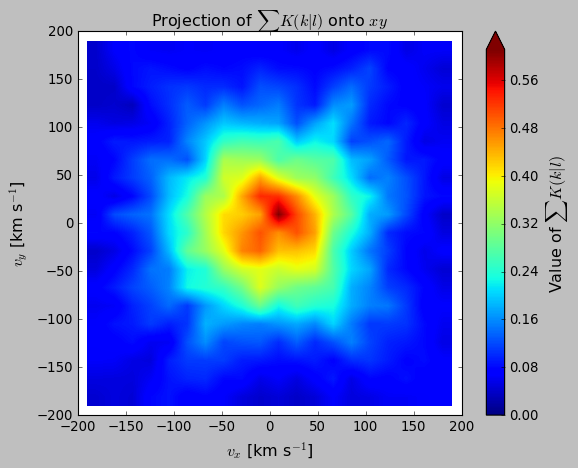

In [47]:
plot_K('xy', pvals, rhatvals, vmin, dv, n)